In [6]:
from model import UNet
import torch


In [7]:
def get_device():
    """Get the device to use for PyTorch operations (CPU or cuda or MPS)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using CUDA


In [3]:
model = UNet(
    in_channels=1,
    out_channels=1
).to(device)


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

common_transforms = A.Compose([
    A.ShiftScaleRotate(p=0.2),
    A.RandomCrop(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    # ToTensorV2()

])

# Not for mask
image_transforms = A.Compose([
    A.RandomBrightnessContrast(p=0.2),  # Solo per l'immagine
    ToTensorV2()
])

c:\Users\lgand\anaconda3\envs\DL\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
from datamodule import BinarySegmentationDataset

ds = BinarySegmentationDataset(
    images_dir='../output_blob/stretched/',
    masks_dir='../output_blob/masks/',
    common_transform= common_transforms,
    image_transform= image_transforms,
)

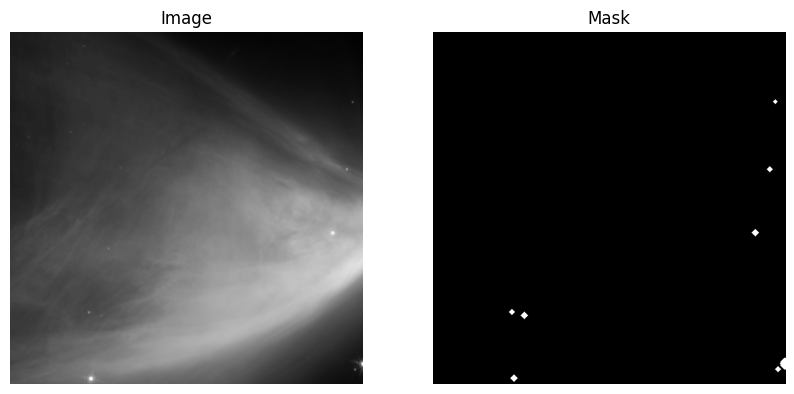

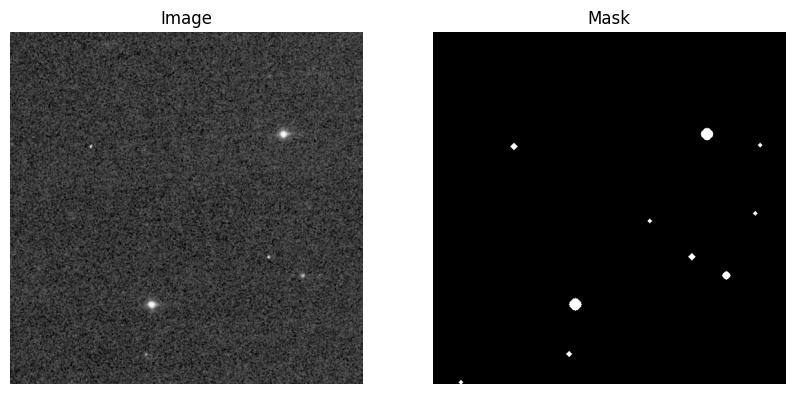

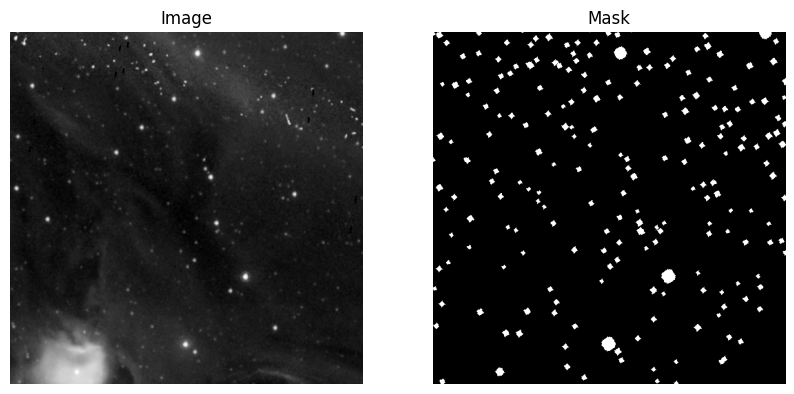

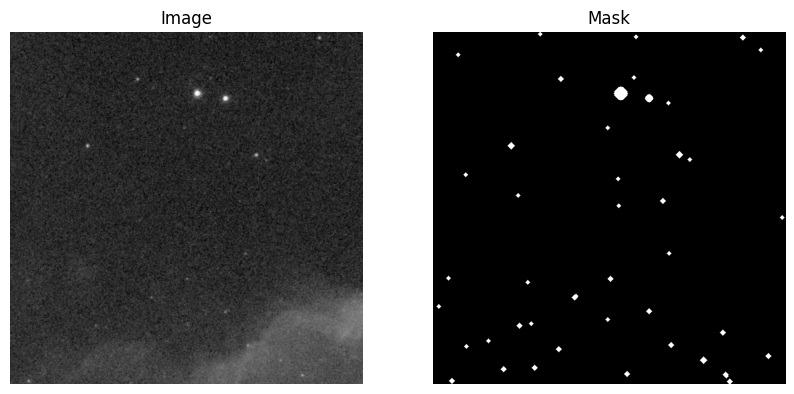

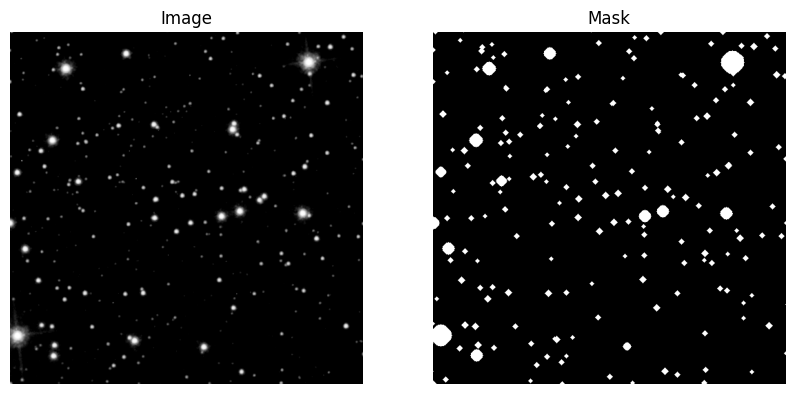

In [6]:
import matplotlib.pyplot as plt
for im, mask in ds:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(im.permute(1, 2, 0).squeeze().numpy(), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(mask.squeeze().numpy(), cmap='gray')
    axs[1].set_title('Mask')
    for ax in axs:
        ax.axis('off')
    plt.show()
    

In [10]:
from datamodule import BinarySegmentationDataModule
dm = BinarySegmentationDataModule(
    train_images_dir='../output_blob/stretched/',
    train_masks_dir='../output_blob/masks/',
    val_images_dir='../output_blob/stretched/',
    val_masks_dir='../output_blob/masks/',

    transforms= {"train_common": common_transforms,
                 "train_image": image_transforms,
                 "val_common": common_transforms,
                 "val_image": image_transforms},
    img_size=(512, 512),
    batch_size=2,
    num_workers=0,      # SE aumento il numero di workers, va molto più lento
)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [93]:
for images, masks in train_loader:
    print(images.shape)  
    print(masks.shape)   
    

torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])


In [20]:
model = UNet(
    in_channels=1,
    out_channels=1
).to(device)


In [21]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(50).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 1.5107
Epoch [2/30], Loss: 1.1760
Epoch [3/30], Loss: 1.6863
Epoch [4/30], Loss: 1.1382
Epoch [5/30], Loss: 1.7039
Epoch [6/30], Loss: 1.6205
Epoch [7/30], Loss: 1.0460
Epoch [8/30], Loss: 1.5213
Epoch [9/30], Loss: 1.2925
Epoch [10/30], Loss: 1.1016
Epoch [11/30], Loss: 1.0368
Epoch [12/30], Loss: 1.0535
Epoch [13/30], Loss: 1.0669
Epoch [14/30], Loss: 1.1714
Epoch [15/30], Loss: 0.8762
Epoch [16/30], Loss: 1.7434
Epoch [17/30], Loss: 1.4381
Epoch [18/30], Loss: 1.1492
Epoch [19/30], Loss: 1.2814
Epoch [20/30], Loss: 1.5115
Epoch [21/30], Loss: 1.1015
Epoch [22/30], Loss: 1.2224
Epoch [23/30], Loss: 1.2382
Epoch [24/30], Loss: 1.3764
Epoch [25/30], Loss: 1.0698
Epoch [26/30], Loss: 1.4355
Epoch [27/30], Loss: 1.1148
Epoch [28/30], Loss: 1.2224
Epoch [29/30], Loss: 1.1692
Epoch [30/30], Loss: 1.1106


In [23]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(50).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=2e-5)

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 0.8774
Epoch [2/30], Loss: 0.8457
Epoch [3/30], Loss: 0.7193
Epoch [4/30], Loss: 1.1005
Epoch [5/30], Loss: 1.0628
Epoch [6/30], Loss: 0.7419
Epoch [7/30], Loss: 0.8554
Epoch [8/30], Loss: 0.7164
Epoch [9/30], Loss: 0.7731
Epoch [10/30], Loss: 0.7887
Epoch [11/30], Loss: 0.7276
Epoch [12/30], Loss: 0.8370
Epoch [13/30], Loss: 0.6668
Epoch [14/30], Loss: 0.6325
Epoch [15/30], Loss: 0.8331
Epoch [16/30], Loss: 0.7075
Epoch [17/30], Loss: 0.8005
Epoch [18/30], Loss: 0.6666
Epoch [19/30], Loss: 0.7432
Epoch [20/30], Loss: 0.8857
Epoch [21/30], Loss: 1.1779
Epoch [22/30], Loss: 0.6248
Epoch [23/30], Loss: 0.8481
Epoch [24/30], Loss: 0.8695
Epoch [25/30], Loss: 0.7586
Epoch [26/30], Loss: 0.7242
Epoch [27/30], Loss: 0.6329
Epoch [28/30], Loss: 0.6813
Epoch [29/30], Loss: 0.5938
Epoch [30/30], Loss: 0.5656


In [26]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(50).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 0.6826
Epoch [2/30], Loss: 0.5485
Epoch [3/30], Loss: 0.5353
Epoch [4/30], Loss: 0.8313
Epoch [5/30], Loss: 0.6128
Epoch [6/30], Loss: 0.5774
Epoch [7/30], Loss: 0.6882
Epoch [8/30], Loss: 0.6659
Epoch [9/30], Loss: 0.7265
Epoch [10/30], Loss: 0.6554
Epoch [11/30], Loss: 0.5486
Epoch [12/30], Loss: 0.8144
Epoch [13/30], Loss: 0.6767
Epoch [14/30], Loss: 0.7363
Epoch [15/30], Loss: 0.6404
Epoch [16/30], Loss: 0.7258
Epoch [17/30], Loss: 0.6937
Epoch [18/30], Loss: 0.9981
Epoch [19/30], Loss: 0.5870
Epoch [20/30], Loss: 0.5645
Epoch [21/30], Loss: 0.5721
Epoch [22/30], Loss: 0.4920
Epoch [23/30], Loss: 0.5645
Epoch [24/30], Loss: 0.7204
Epoch [25/30], Loss: 0.8900
Epoch [26/30], Loss: 0.6919
Epoch [27/30], Loss: 0.6696
Epoch [28/30], Loss: 0.5994
Epoch [29/30], Loss: 0.5955
Epoch [30/30], Loss: 0.5762


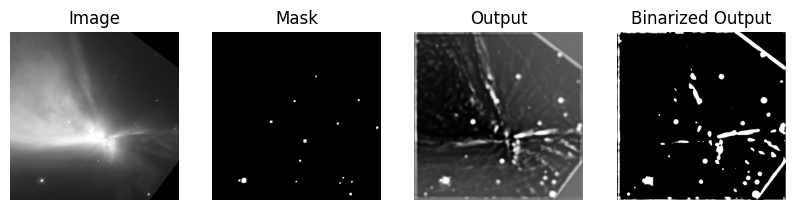

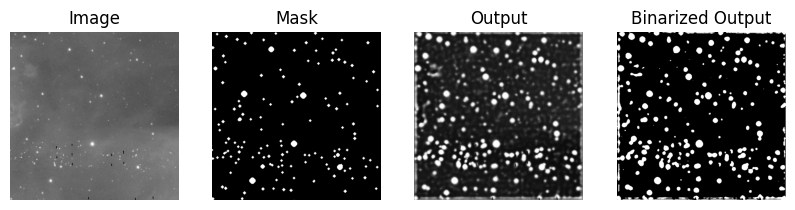

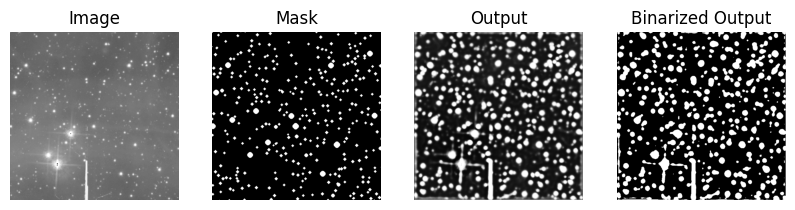

In [30]:
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        outputs = model(images)
        # outputs = outputs.squeeze(1)  # [B, 1, H, W] -> [B, H, W] if needed
        loss = criterion(outputs, masks)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images[0].cpu().permute(1, 2, 0).squeeze().numpy(), cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(masks[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(1, 4, 3)
        outputs = torch.sigmoid(outputs)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Output')
        plt.axis('off')
        # binarize the output
        outputs = (outputs > 0.5).float()
        plt.subplot(1, 4, 4)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Binarized Output')
        plt.axis('off')

In [31]:
# save model
torch.save(model.state_dict(), 'checkpoints/seg_0.pth')

In [11]:
from model import UNet
import torch
model = UNet(
    in_channels=1,
    out_channels=1
)
model.load_state_dict(torch.load("checkpoints/seg__gen_1.pth"))
model = model.to(device)
model.eval()

C:\Users\lgand\AppData\Local\Temp\ipykernel_16988\1974319688.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/seg__gen_1.pth

UNet(
  (down1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (

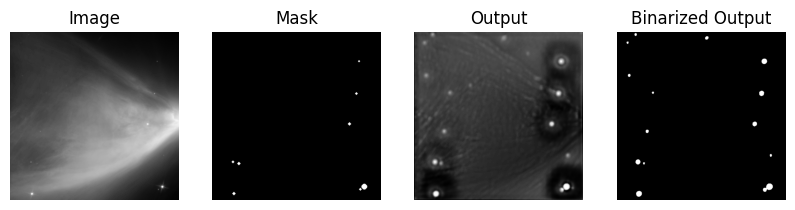

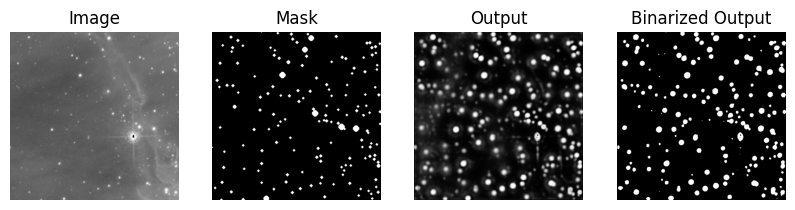

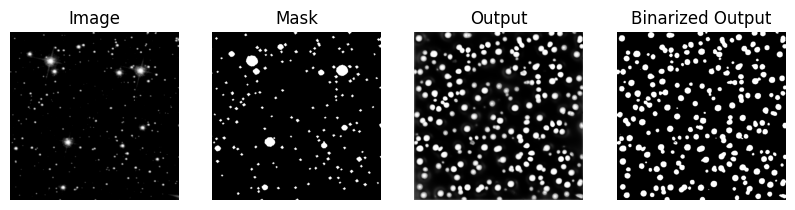

In [15]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        outputs = model(images)
        # outputs = outputs.squeeze(1)  # [B, 1, H, W] -> [B, H, W] if needed

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images[0].cpu().permute(1, 2, 0).squeeze().numpy(), cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(masks[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(1, 4, 3)
        outputs = torch.sigmoid(outputs)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Output')
        plt.axis('off')
        # binarize the output
        outputs = (outputs > 0.5).float()
        plt.subplot(1, 4, 4)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Binarized Output')
        plt.axis('off')